# 多类逻辑回归——从零开始

如果你读过了[从0开始的线性回归](linear-regression-scratch.md)，那么最难的部分已经过去了。现在你知道如果读取和操作数据，如何构造目标函数和对它求导，如果定义损失函数，模型和求解。

下面我们来看一个稍微有意思一点的问题，如何使用多类逻辑回归进行多类分类。这个模型跟线性回归的主要区别在于输出节点从一个变成了多个。

![](../img/simple-softmax-net.png)


## 获取数据

演示这个模型的常见数据集是手写数字识别MNIST，它长这个样子。

![](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/example/mnist.png)

这里我们用了一个稍微复杂点的数据集，它跟MNIST非常像，但是内容不再是分类数字，而是服饰。我们通过gluon的data.vision模块自动下载这个数据。

In [1]:
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet import image

def apply_aug_list(img, augs):
    for f in augs:
        img = f(img)
    return img

train_augs = [
    image.HorizontalFlipAug(.5)
]
test_augs = [
]

def get_transform(augs):
    def transform(data, label):
        # data: sample x height x width x channel
        # label: sample
        data = data.astype('float32')/255
        if augs is not None:
            # apply to each sample one-by-one and then stack
            data = nd.stack(*[
                apply_aug_list(d, augs) for d in data])
        return data, label.astype('float32')
    return transform

def transform(data, label):
    return data.astype('float32')/255, label.astype('float32')
mnist_train = gluon.data.vision.MNIST(train=True, transform=get_transform(train_augs))
mnist_test = gluon.data.vision.MNIST(train=False, transform=get_transform(test_augs))

打印一个样本的形状和它的标号

In [2]:
data, label = mnist_train[0]
('example shape: ', data.shape, 'label:', label)

('example shape: ', (28, 28, 1), 'label:', 5.0)

我们画出前几个样本的内容，和对应的文本标号

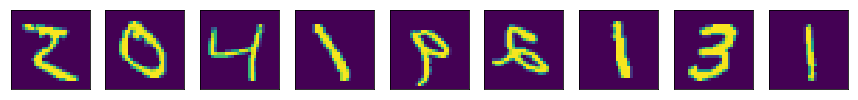

[ 5.  0.  4.  1.  9.  2.  1.  3.  1.]


In [3]:
import matplotlib.pyplot as plt

def show_images(images):
    n = images.shape[0]
    _, figs = plt.subplots(1, n, figsize=(15, 15))
    for i in range(n):
        figs[i].imshow(images[i].reshape((28, 28)).asnumpy())
        figs[i].axes.get_xaxis().set_visible(False)
        figs[i].axes.get_yaxis().set_visible(False)
    plt.show()

def get_text_labels(label):
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress,', 'coat',
        'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ]
    return [text_labels[int(i)] for i in label]

data, label = mnist_train[0:9]
show_images(data)
print(label)

## 数据读取

虽然我们可以像前面那样通过`yield`来定义获取批量数据函数，这里我们直接使用gluon.data的DataLoader函数，它每次`yield`一个批量。

In [4]:
batch_size = 256
train_data = gluon.data.DataLoader(mnist_train, batch_size, shuffle=True)
test_data = gluon.data.DataLoader(mnist_test, batch_size, shuffle=False)

注意到这里我们要求每次从训练数据里读取一个由随机样本组成的批量，但测试数据则不需要这个要求。

## 初始化模型参数

跟线性模型一样，每个样本会表示成一个向量。我们这里数据是 28 * 28 大小的图片，所以输入向量的长度是 28 * 28 = 784。因为我们要做多类分类，我们需要对每一个类预测这个样本属于此类的概率。因为这个数据集有10个类型，所以输出应该是长为10的向量。这样，我们需要的权重将是一个 784 * 10 的矩阵：

In [5]:
num_inputs = 784
num_outputs = 10

W = nd.random_normal(shape=(num_inputs, num_outputs))
b = nd.random_normal(shape=num_outputs)

params = [W, b]

同之前一样，我们要对模型参数附上梯度：

In [6]:
for param in params:
    param.attach_grad()

## 定义模型

在线性回归教程里，我们只需要输出一个标量`yhat`使得尽可能的靠近目标值。但在这里的分类里，我们需要属于每个类别的概率。这些概率需要值为正，而且加起来等于1. 而如果简单的使用 $\boldsymbol{\hat y} = \boldsymbol{W} \boldsymbol{x}$, 我们不能保证这一点。一个通常的做法是通过softmax函数来将任意的输入归一化成合法的概率值。

In [7]:
from mxnet import nd
def softmax(X):
    exp = nd.exp(X)
    # 假设exp是矩阵，这里对行进行求和，并要求保留axis 1，
    # 就是返回 (nrows, 1) 形状的矩阵
    partition = exp.sum(axis=1, keepdims=True)
    return exp / partition

可以看到，对于随机输入，我们将每个元素变成了非负数，而且每一行加起来为1。

In [8]:
X = nd.random_normal(shape=(2,5))
X_prob = softmax(X)
print(X_prob)
print(X_prob.sum(axis=1))


[[ 0.07024596  0.38768554  0.06740031  0.21249865  0.26216954]
 [ 0.06539094  0.1500023   0.36792335  0.02470051  0.39198291]]
<NDArray 2x5 @cpu(0)>

[ 1.  1.]
<NDArray 2 @cpu(0)>


现在我们可以定义模型了：

In [9]:
def net(X):
    return softmax(nd.dot(X.reshape((-1,num_inputs)), W) + b)

## 交叉熵损失函数

我们需要定义一个针对预测为概率值的损失函数。其中最常见的是交叉熵损失函数，它将两个概率分布的负交叉熵作为目标值，最小化这个值等价于最大化这两个概率的相似度。

具体来说，我们先将真实标号表示成一个概率分布，例如如果`y=1`，那么其对应的分布就是一个除了第二个元素为1其他全为0的长为10的向量，也就是 `yvec=[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]`。那么交叉熵就是`yvec[0]*log(yhat[0])+...+yvec[n]*log(yhat[n])`。注意到`yvec`里面只有一个1，那么前面等价于`log(yhat[y])`。所以我们可以定义这个损失函数了

In [10]:
def cross_entropy(yhat, y):
    return - nd.pick(nd.log(yhat), y)

## 计算精度

给定一个概率输出，我们将预测概率最高的那个类作为预测的类，然后通过比较真实标号我们可以计算精度：

In [11]:
def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

我们可以评估一个模型在这个数据上的精度。（这两个函数我们之后也会用到，所以也都保存在[../utils.py](../utils.py)。）

In [12]:
def evaluate_accuracy(data_iterator, net):
    acc = 0.
    for data, label in data_iterator:
        output = net(data)
        acc += accuracy(output, label)
    return acc / len(data_iterator)

因为我们随机初始化了模型，所以这个模型的精度应该大概是`1/num_outputs = 0.1`.

In [13]:
evaluate_accuracy(test_data, net)

0.11845703125

## 训练

训练代码跟前面的线性回归非常相似：

In [14]:
import sys
sys.path.append('..')
from utils import SGD
from mxnet import autograd

learning_rate = .1

for epoch in range(50):
    train_loss = 0.
    train_acc = 0.
    for data, label in train_data:
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label)
        loss.backward()
        # 将梯度做平均，这样学习率会对batch size不那么敏感
        SGD(params, learning_rate/batch_size)

        train_loss += nd.mean(loss).asscalar()
        train_acc += accuracy(output, label)

    test_acc = evaluate_accuracy(test_data, net)
    print("Epoch %d. Loss: %f, Train acc %f, Test acc %f" % (
        epoch, train_loss/len(train_data), train_acc/len(train_data), test_acc))

Epoch 0. Loss: 4.300033, Train acc 0.425139, Test acc 0.632812
Epoch 1. Loss: 1.685699, Train acc 0.680131, Test acc 0.738184
Epoch 2. Loss: 1.254052, Train acc 0.748720, Test acc 0.778125
Epoch 3. Loss: 1.062114, Train acc 0.782402, Test acc 0.800684
Epoch 4. Loss: 0.949444, Train acc 0.801917, Test acc 0.817578
Epoch 5. Loss: 0.871440, Train acc 0.815071, Test acc 0.829199
Epoch 6. Loss: 0.813980, Train acc 0.824701, Test acc 0.837598


KeyboardInterrupt: 

## 预测

训练完成后，现在我们可以演示对输入图片的标号的预测

In [ ]:
data, label = mnist_test[40:49]
show_images(data)
print('true labels')
print(label)

predicted_labels = net(data).argmax(axis=1)
print('predicted labels')
print((predicted_labels.asnumpy()))

## 结论

与前面的线性回归相比，你会发现多类逻辑回归教程的结构跟其非常相似：获取数据、定义模型及优化算法和求解。事实上，几乎所有的实际神经网络应用都有着同样结构。他们的主要区别在于模型的类型和数据的规模。每一两年会有一个新的优化算法出来，但它们基本都是随机梯度下降的变种。

## 练习

尝试增大学习率，你会马上发现结果变得很糟糕，精度基本徘徊在随机的0.1左右。这是为什么呢？提示：

- 打印下output看看是不是有什么异常
- 前面线性回归还好好的，这里我们在net()里加了什么呢？
- 如果给exp输入个很大的数会怎么样？
- 即使解决exp的问题，求出来的导数是不是还是不稳定？

请仔细想想再去对比下我们小伙伴之一@[pluskid](https://github.com/pluskid)早年写的一篇[blog解释这个问题](http://freemind.pluskid.org/machine-learning/softmax-vs-softmax-loss-numerical-stability/)，看看你想的是不是不一样。

**吐槽和讨论欢迎点**[这里](https://discuss.gluon.ai/t/topic/741)